In [1]:
import logging
from pathlib import Path

import httpimport
import matplotlib.pyplot as plt

from utils import ILSVRC2014Sample, to_np, to_tensor, CUDA, VGG, load_image

logging.getLogger("PIL").setLevel(logging.INFO)


with httpimport.github_repo(
    "janchorowski", "nn_assignments", module="common", branch="nn18"
):
    import common.plotting


In [2]:
![ -e ../data/ilsvrc_subsample.tar.bz2 ] || gdown 'https://drive.google.com/uc?id=1Y9xfTe9rjvFiX5N9DZqCRm83zHtQUBDC' -O ../data/ilsvrc_subsample.tar.bz2
![ -d ../data/ilsvrc_subsample ] || tar -jxf ../data/ilsvrc_subsample.tar.bz2 -C ../data

In [3]:
vgg = VGG("vgg19")
if CUDA:
    vgg.cuda()

In [4]:
# List layers in the model
print("Feature layers")
print("--------------")
for name, layer in zip(vgg.feature_names, vgg.features):
    print("{1: <12} {0: <8}  ({2}".format(name, *str(layer).split("(", 1)))
print("\nClassifier layers")
print("-----------------")
for layer in vgg.classifier:
    print("{: <12}({}".format(*str(layer).split("(", 1)))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace=True)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace=True)
MaxPool2d    pool1     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace=True)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace=True)
MaxPool2d    pool2     (kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace=True)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace=True)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride

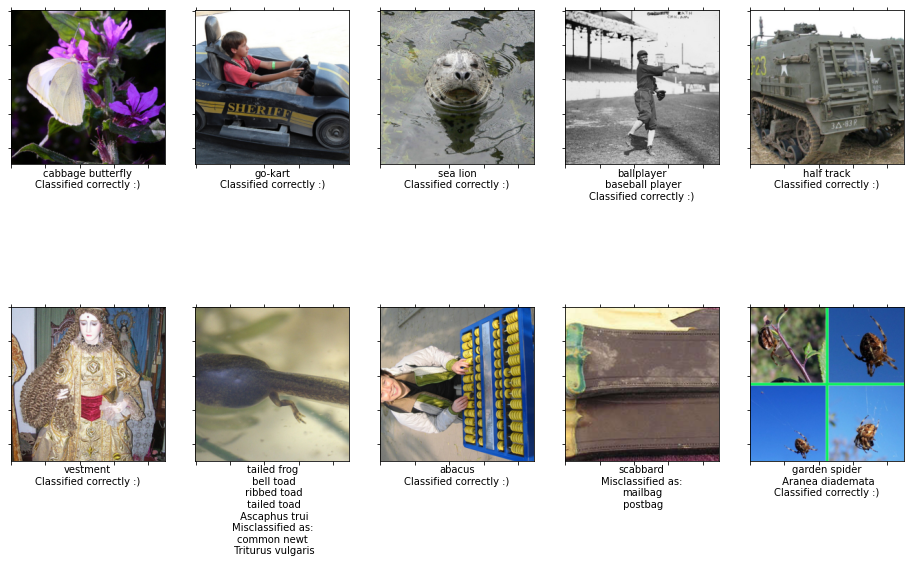

In [5]:
ilsvrc = ILSVRC2014Sample(40)
vgg.eval()

plt.figure(figsize=(16, 10))
for i in range(10):
    img = ilsvrc.data[30 + i]
    label = ilsvrc.labels[30 + i]

    img_torch = to_tensor(img)
    predicted_label_id = to_np(vgg.predict(img_torch))[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]

    desc = ilsvrc.label_to_desc[label].split(",")
    if label == predicted_label:
        desc.append("Classified correctly :)")
    else:
        desc.append("Misclassified as:")
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(","))

    ax = plt.subplot(2, 5, 1 + i)
    ax.set_xlabel("\n".join(desc))  # , {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis="both", which="both", bottom="off", left="off", top="off")
    ax.grid(False)
    plt.imshow(img)

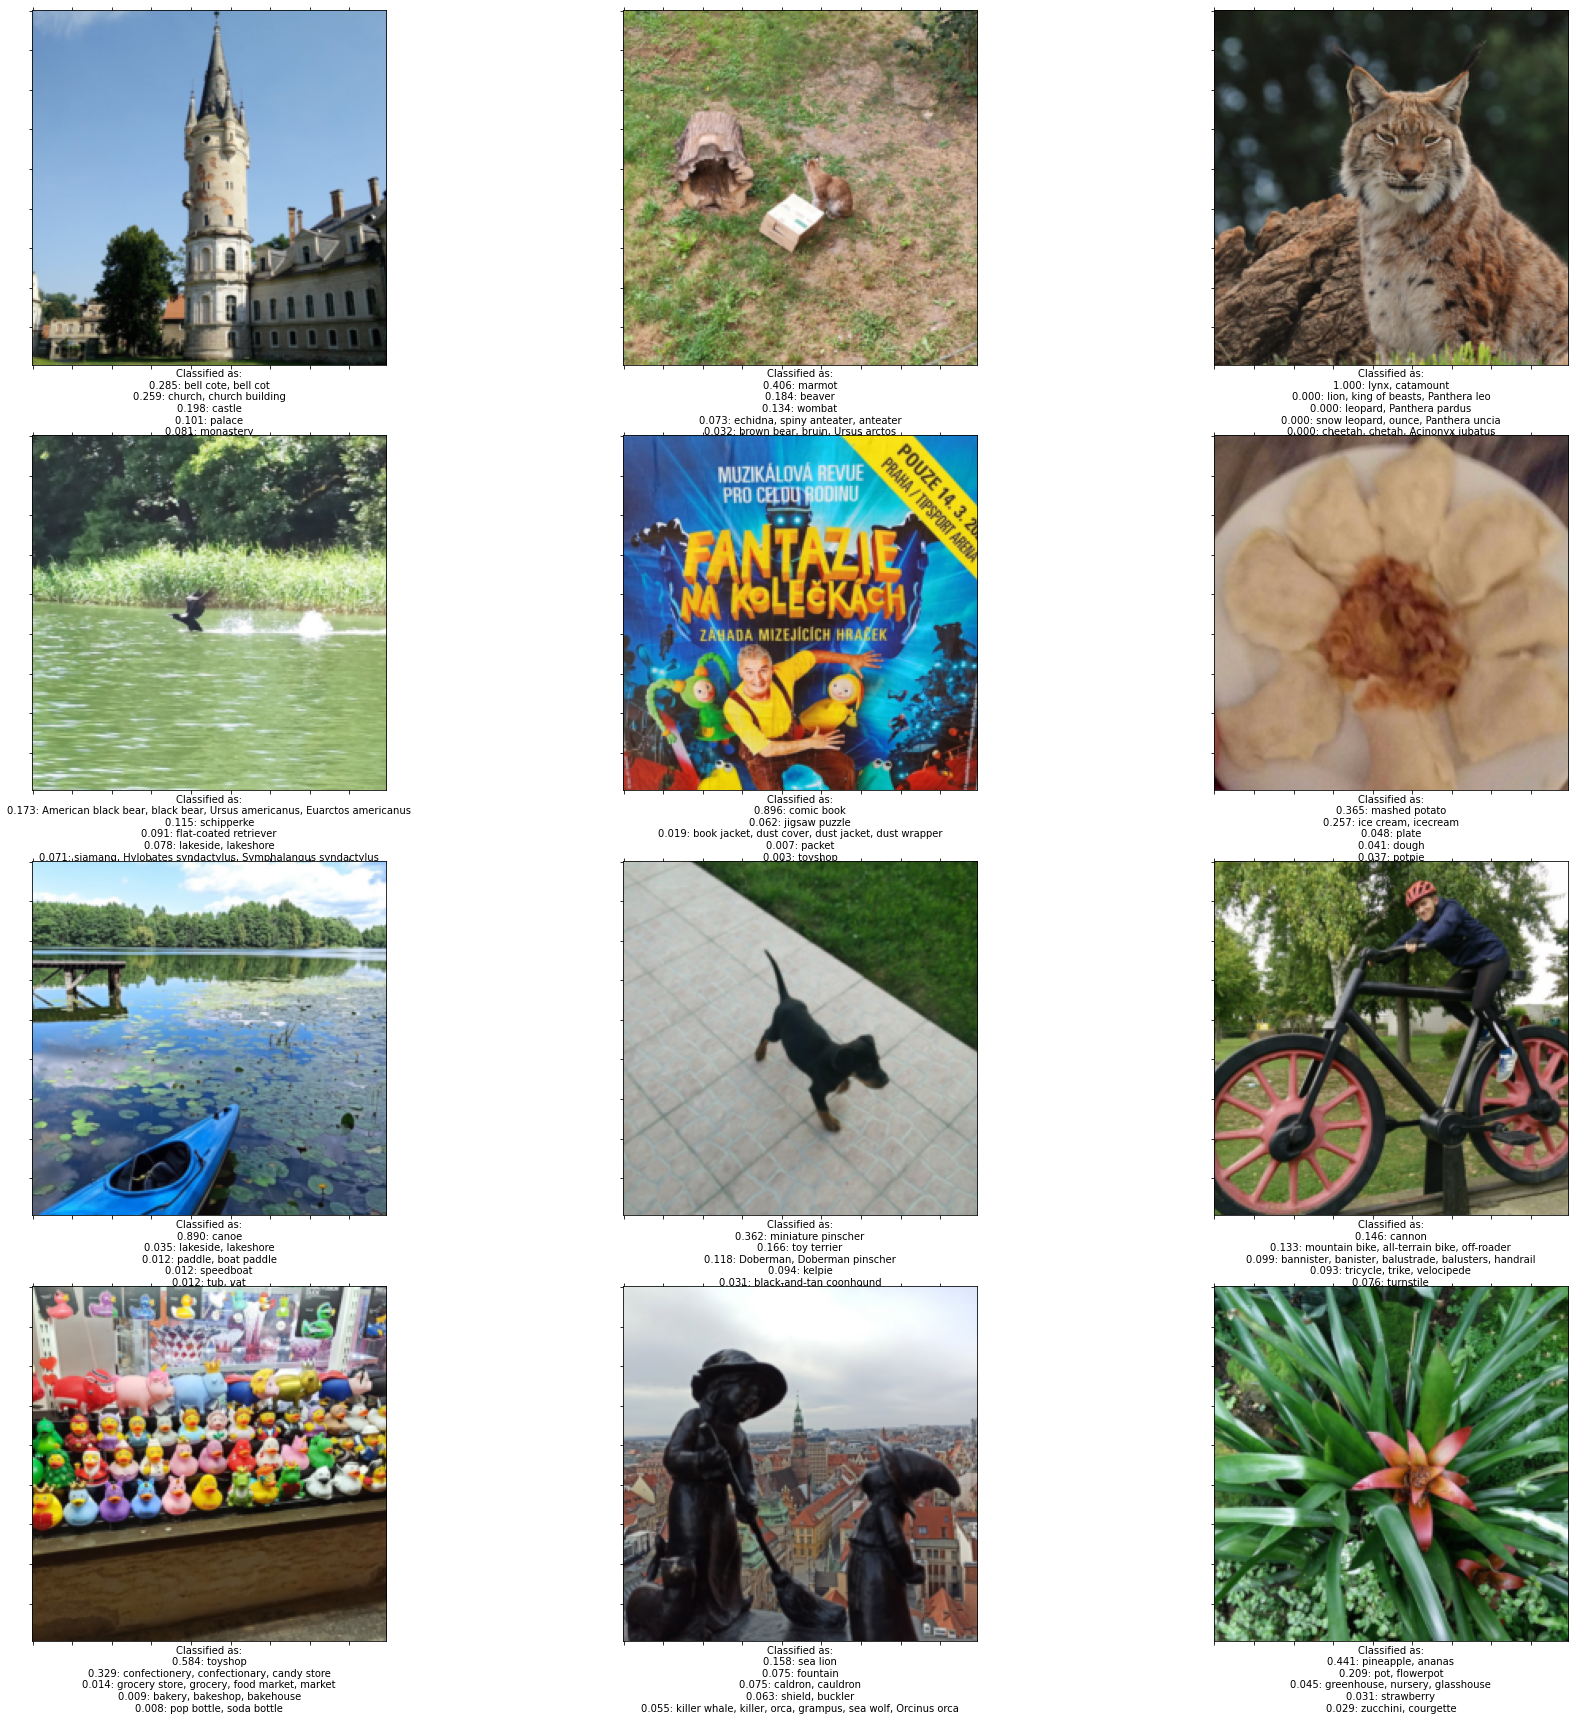

In [6]:
plt.figure(figsize=(30, 30))
for i, filepath in enumerate(Path("../data/new_images").iterdir()):
    img = load_image(filepath)
    img_torch = to_tensor(img)
    probs = vgg.probabilities(img_torch).squeeze()
    top5 = probs.sort(-1, descending=True)[1][:5]

    predicted_label_id = to_np(vgg.predict(img_torch))[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]
    desc = ["Classified as:"]
    for pred_id in top5:
        pred_label = ilsvrc.label_to_desc[ilsvrc.id_to_label[pred_id.item()]]
        pred_prob = probs[pred_id].item()
        desc.append(f"{pred_prob:.3f}: {pred_label}")

    ax = plt.subplot(4, 3, 1 + i)
    ax.set_xlabel("\n".join(desc))  # , {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis="both", which="both", bottom="off", left="off", top="off")
    ax.grid(False)
    plt.imshow(img)